In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier


In [3]:
df = pd.read_csv('../../data/preprocessed_AQI_data.csv')
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
0,130,10126,51,2,1,0,36,0,0,0,51,2,44.7444,44.2031
1,22,10140,41,0,1,0,5,0,1,0,41,0,-5.2900,-44.4900
2,75,10163,66,2,1,0,39,0,2,0,66,2,37.1667,15.1833
3,123,10185,34,0,1,0,34,0,0,0,20,0,53.0167,20.8833
4,166,10243,54,2,1,0,14,0,11,0,54,2,16.1005,-88.8074


In [4]:
from sklearn.model_selection import train_test_split

# shuffle the data before splitting
df_shuffled = df.sample(frac=1, random_state=19)  
X = df_shuffled.drop(["AQI Category"], axis=1)
y = df_shuffled["AQI Category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=22
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(2845, 13) (11384, 13)
(2845,) (11384,)


In [5]:
y.unique()

array([3, 2, 4, 0, 1, 5])

In [6]:
params = {'n_neighbors': [2,3,5,7,9,11],
          'p': [1,2],
          'metric': ['cosine', 'euclidean', 'minkowski']}

In [7]:
clf = KNeighborsClassifier(n_neighbors=3, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [8]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [9]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
rep1 = classification_report(y_test, y_pred)
print(rep1)

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      5301
           1       0.80      0.10      0.17        41
           2       0.62      0.65      0.64      4741
           3       0.66      0.54      0.59       618
           4       0.44      0.17      0.24       588
           5       0.32      0.06      0.11        95

    accuracy                           0.66     11384
   macro avg       0.59      0.38      0.41     11384
weighted avg       0.65      0.66      0.65     11384



### Applying grid search

In [10]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)   

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'metric': ['cosine', 'euclidean', 'minkowski'],
                         'n_neighbors': [2, 3, 5, 7, 9, 11], 'p': [1, 2]},
             scoring='accuracy')

In [11]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'metric': 'cosine', 'n_neighbors': 3, 'p': 1}
Best Accuracy: 0.8063268892794376


In [12]:
best_knn = grid_search.best_estimator_
# Evaluate the best model on the test set
test_accuracy = best_knn.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8204497540407589


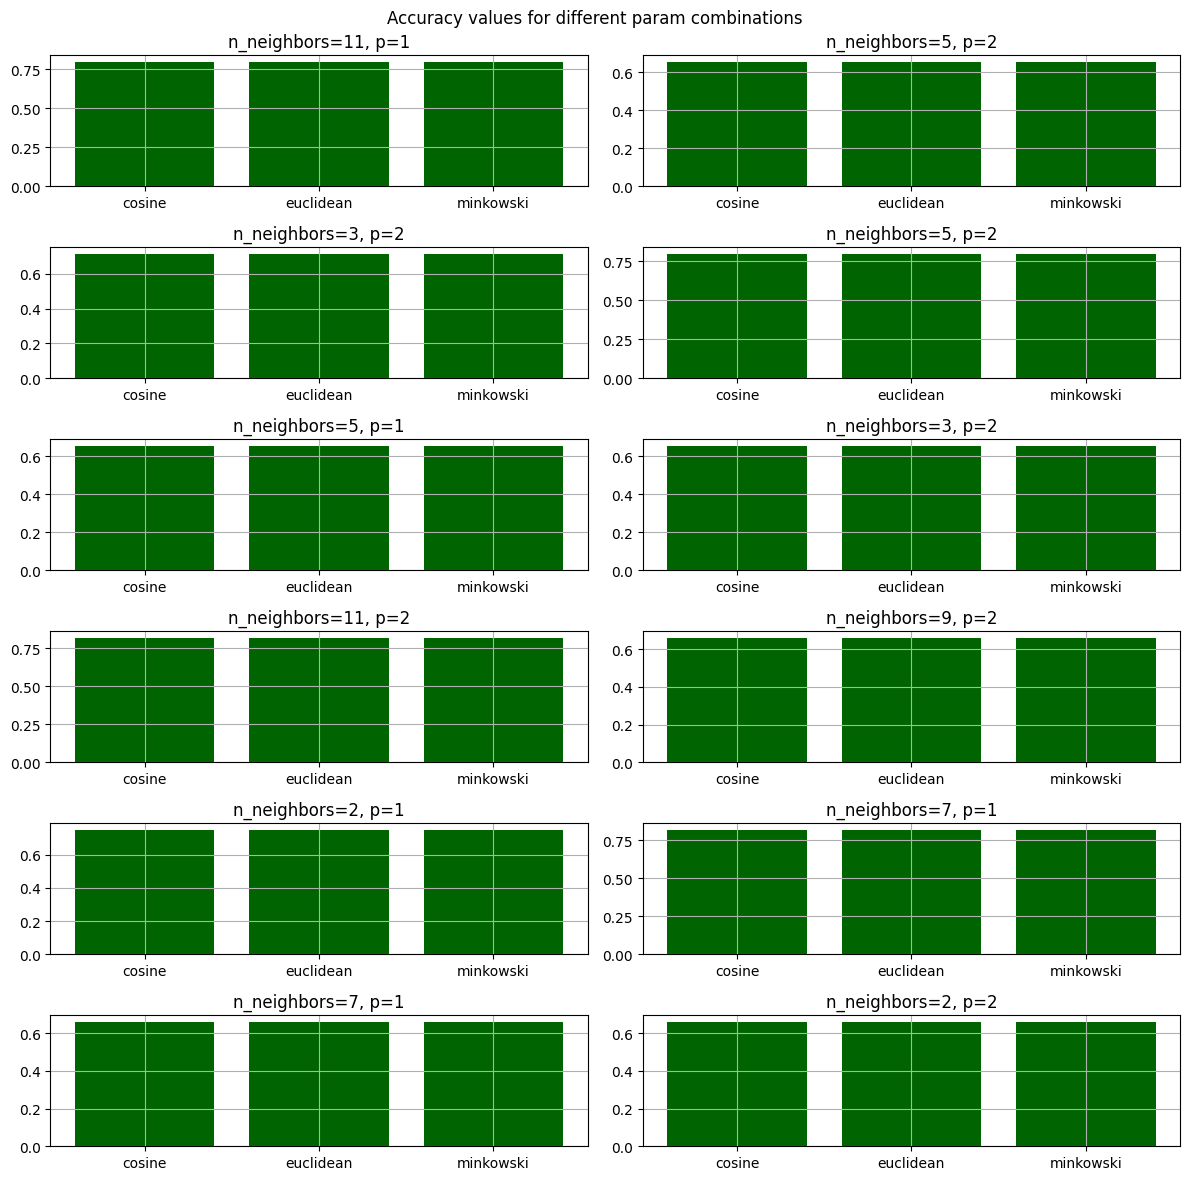

In [13]:
import numpy as np
import matplotlib.pyplot as plt

accuracies = []
param_values = set() 
for n_neighbors in params['n_neighbors']:
    for p in params['p']:
        for metric in params['metric']:
            if (n_neighbors, p, metric) not in param_values:
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, metric=metric)
                knn.fit(X_train, y_train)
                accuracy = knn.score(X_test, y_test)
                accuracies.append(accuracy)
                param_values.add((n_neighbors, p, metric))

# Create subplots based on unique parameter combinations
fig, axs = plt.subplots(len(params['n_neighbors']), len(params['p']), figsize=(12, 12))
fig.suptitle('Accuracy values for different param combinations')
for i, ax in enumerate(axs.flat):
    n_neighbors, p, metric = list(param_values)[i]
    ax.bar(range(len(params['metric'])), accuracies[i::len(param_values)], color='darkgreen')
    ax.set_xticks(range(len(params['metric'])))
    ax.set_xticklabels(params['metric'])
    ax.set_title(f'n_neighbors={n_neighbors}, p={p}')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [14]:
y_preds = best_knn.predict(X_test)
rep2 = classification_report(y_preds, y_test)
print(rep2)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5280
           1       0.41      0.35      0.38        49
           2       0.84      0.81      0.83      4905
           3       0.73      0.63      0.68       716
           4       0.36      0.52      0.42       401
           5       0.11      0.30      0.16        33

    accuracy                           0.82     11384
   macro avg       0.55      0.58      0.56     11384
weighted avg       0.83      0.82      0.82     11384



## Improving the accuracy

In [15]:
# to do : add scaling of the data
# classificatin report

In [88]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler() # this gives better results
# mm = MinMaxScaler()

In [89]:
X_train_rescaled = ss.fit_transform(X_train)
X_test_rescaled = ss.fit_transform(X_test)

In [90]:
clf_ = KNeighborsClassifier(n_neighbors=3, p=2)
clf_.fit(X_train_rescaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [91]:
y_pred = clf_.predict(X_test_rescaled)

In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

# here we define different scorers metrics
scorer_f1 = make_scorer(f1_score, average='weighted')
scorer_precision = make_scorer(precision_score, average='weighted', zero_division=1)
scorer_recall = make_scorer(recall_score, average='weighted')
scorer_accuracy = make_scorer(accuracy_score)

# Cwe save them in a dict for easier accessing
scorers = {'f1': scorer_f1, 'precision': scorer_precision, 'accuracy': scorer_accuracy, 'recall': scorer_recall}

for scorer_name, scorer in scorers.items():
    scores = cross_val_score(clf_, X_train_rescaled, y_train, cv=5, scoring=scorer)
    print(f"{scorer_name.capitalize()} scores:", scores)


F1 scores: [0.98669083 0.98210942 0.9894529  0.99244009 0.98346742]
Precision scores: [0.9876844  0.98363957 0.98950278 0.99269552 0.98564902]
Accuracy scores: [0.98769772 0.98242531 0.98945518 0.99297012 0.98418278]
Recall scores: [0.98769772 0.98242531 0.98945518 0.99297012 0.98418278]


In [93]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5302
           1       0.59      1.00      0.74        24
           2       1.00      1.00      1.00      4752
           3       0.95      0.87      0.91       676
           4       0.88      0.95      0.92       546
           5       0.69      0.79      0.74        84

    accuracy                           0.99     11384
   macro avg       0.85      0.93      0.88     11384
weighted avg       0.99      0.99      0.99     11384



In [94]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9870871398453971


In [95]:
rep_ = classification_report(y_pred, y_test)
print(rep_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5302
           1       0.59      1.00      0.74        24
           2       1.00      1.00      1.00      4752
           3       0.95      0.87      0.91       676
           4       0.88      0.95      0.92       546
           5       0.69      0.79      0.74        84

    accuracy                           0.99     11384
   macro avg       0.85      0.93      0.88     11384
weighted avg       0.99      0.99      0.99     11384



In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [97]:
conf_matrix = confusion_matrix(y_pred, y_test)
conf_matrix


array([[5300,    0,    2,    0,    0,    0],
       [   0,   24,    0,    0,    0,    0],
       [   1,    0, 4738,    0,   13,    0],
       [   0,    1,    0,  590,   56,   29],
       [   0,    0,    1,   26,  519,    0],
       [   0,   16,    0,    2,    0,   66]])

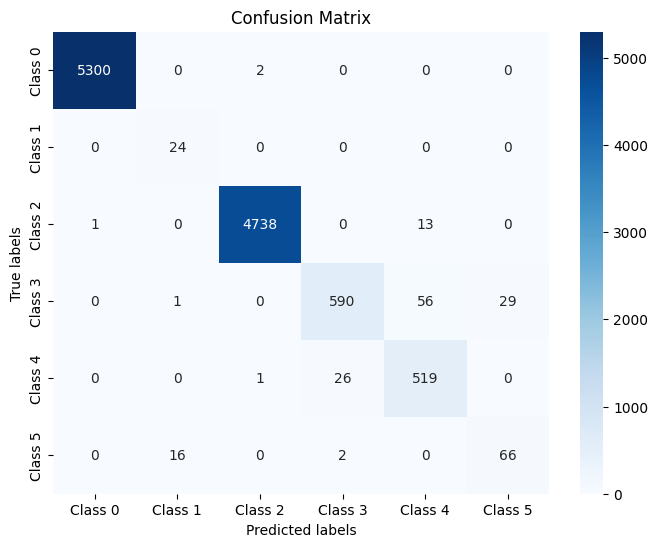

In [98]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Results analysis : 
As we can see, there is still room for imporvement : 
- There are 8 samples that belong to class 5 but were classfied as Class 1
- There are 2 samples that belong to class 0 but were classfiied as Class 2
- THere are 52 samples that belong to Class 4 but were classified as class 3

Let's now try **techniques to mititgate the imbalance** in our dataset 

In [99]:
y_test.value_counts()

AQI Category
0    5301
2    4741
3     618
4     588
5      95
1      41
Name: count, dtype: int64

In [100]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [101]:
# applying smote oversampling for the minority class
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_rescaled, y_train)


Let's now check the data distributoin after resampling

In [102]:
y_train_resampled.value_counts()

AQI Category
0    1369
2    1369
3    1369
5    1369
4    1369
1    1369
Name: count, dtype: int64

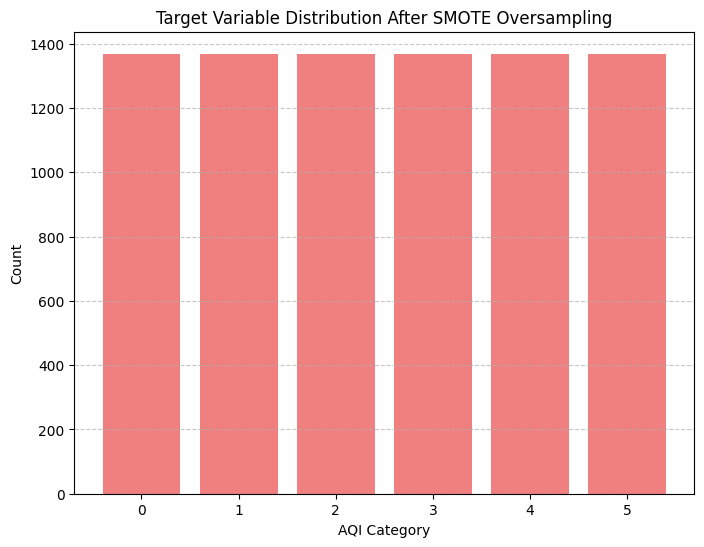

In [103]:
unique_classes, class_counts = np.unique(y_train_resampled, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color='lightcoral')
plt.title('Target Variable Distribution After SMOTE Oversampling')
plt.xlabel('AQI Category')
plt.ylabel('Count')
plt.xticks(unique_classes)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [104]:
knn = KNeighborsClassifier(n_neighbors=3, p=2, metric='cosine')
knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [105]:
y_pred = knn.predict(X_test_rescaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5301
           1       1.00      0.66      0.79        41
           2       1.00      0.99      0.99      4741
           3       0.88      0.92      0.90       618
           4       0.91      0.93      0.92       588
           5       0.57      0.77      0.65        95

    accuracy                           0.98     11384
   macro avg       0.89      0.88      0.88     11384
weighted avg       0.98      0.98      0.98     11384



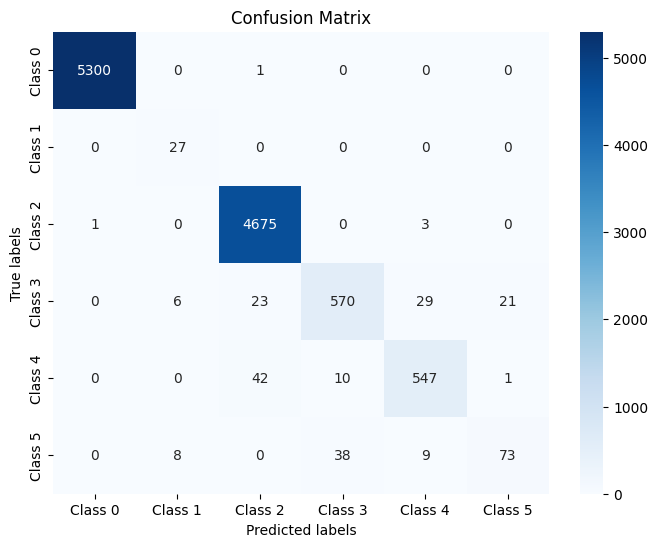

In [106]:
conf_matrix_ = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(8, 6))
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
sns.heatmap(conf_matrix_, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [107]:

accuracy_ = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_)


Accuracy: 0.983134223471539
